In [7]:
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
from pynestml.frontend.pynestml_frontend import generate_nest_target

In [8]:
def generate_code(neuron_model: str, models_path=""):
    """
    Generate NEST code for neuron model with gap junction support.
    Parameters
    ----------
    neuron_model : str
        Name of the neuron model to compile. This should correspond to a 
        .nestml file containing the neuron model definition.
    models_path : str, optional
        Path to the directory containing the NESTML model files.
        Default is empty string (current directory).
    """
    codegen_opts = {"gap_junctions": {"enable": True,
                                        "gap_current_port": "I_stim",
                                        "membrane_potential_variable": "V_m"}}

    files = os.path.join(models_path, neuron_model + ".nestml")
    generate_nest_target(input_path=files,
                            logging_level="WARNING",
                            module_name="nestml_gap_" + neuron_model + "_module",
                            suffix="_nestml",
                            codegen_opts=codegen_opts)

    return neuron_model

generate_code(neuron_model="aeif_cond_exp_neuron", models_path="../nest_models")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Jul 13 2025 01:06:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[11,aeif_cond_exp_neuron_nestml, WARNING, [103:8;103:17]]: Variable 'a' has the same name as a physical unit!


CMake Warning:
  Ignoring empty string ("") provided on the command line.


-- The CXX compiler identification is GNU 9.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_gap_aeif_cond_exp_neuron_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : 
NEST compiler flags  :  -std=c++17 -Wall -fopenmp -pthread -O2 -fdiagnostics-color=auto
NEST include dirs    :  -I/home/niccolo/Projects/Neuro/cereb_env/include/nest -I/usr/include -I/usr/include -I/usr/include -I/usr/lib/x86_64-linux-gnu/openmpi/include/openmpi -I/usr/lib/x86_64-linux-gnu/openmpi/include -I/usr/include
NEST libraries flags : -L/home/niccolo/Projects/Neuro/cereb_env/lib/nest -lnest -l

'aeif_cond_exp_neuron'

In [9]:

nest.ResetKernel()
nest.Install("nestml_gap_aeif_cond_exp_neuron_module")
nest.resolution = 0.05


Sep 04 01:36:44 Install [Info]: 
    loaded module nestml_gap_aeif_cond_exp_neuron_module

Sep 04 01:36:44 aeif_cond_exp_neuron_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Sep 04 01:36:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.05 ms.


In [10]:
 nest.GetDefaults('aeif_cond_exp_neuron_nestml')['recordables']

('V_m', 'w', 'refr_t', 'g_inh__X__inh_spikes', 'g_exc__X__exc_spikes')

In [11]:


neuron = nest.Create("aeif_cond_exp_neuron_nestml", 2)
neuron.I_e = 650.0
neuron[0].V_m = -10.0 

In [12]:
vm = nest.Create("voltmeter", params={"interval": 0.1})
nest.Connect(vm, neuron, "all_to_all")

In [13]:
with_gaps = True
if with_gaps:
    nest.Connect(
        neuron, neuron, 
        {"rule": "all_to_all", "allow_autapses": False}, 
        {"synapse_model": "gap_junction", "weight": 5}
    )


Sep 04 01:36:44 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Sep 04 01:36:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 5000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Sep 04 01:36:44 SimulationManager::run [Info]: 
    Simulation finished.


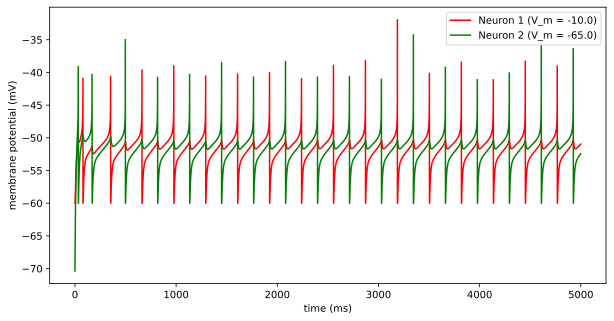

In [14]:
nest.Simulate(5000.0)

senders = vm.events["senders"]
times = vm.events["times"]
v_m_values = vm.events["V_m"]


plt.figure(figsize=(10, 5))
plt.plot(
    times[np.where(senders == 1)], v_m_values[np.where(senders == 1)], "r-",
    label="Neuron 1 (V_m = -10.0)")
plt.plot(
    times[np.where(senders == 2)], v_m_values[np.where(senders == 2)], "g-", label="Neuron 2 (V_m = -65.0)")
plt.legend(loc='upper right')
plt.xlabel("time (ms)")
plt.ylabel("membrane potential (mV)")
plt.savefig(f"images/aeif_cond_exp_{'with' if with_gaps else 'without'}")
plt.show()
